# Imports

In [142]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.inspection import permutation_importance
import ta

from tqdm.notebook import tqdm
tqdm.pandas()

import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.metrics import f1_score
from imblearn.under_sampling import RandomUnderSampler
pd.set_option('display.float_format', lambda x: '%.3f' % x)
np.set_printoptions(suppress=True)
from pprint import pprint

import gc
import optuna
from sklearn.feature_selection import RFE


In [143]:
df = pd.read_csv('Data/Training/pair_features1_300_120.csv')
df.head()

,Ticker_P1,Date,High_P1,Low_P1,Volume_P1,Close_P1,Ticker_P2,High_P2,Low_P2,Volume_P2,Close_P2,abs_spread,abs_spread_mean,abs_spread_std,abs_spread_mean_MA,abs_spread_std_MA,pnls
0,WELL,2001-02-08 00:00:00,18.850,18.710,61000.000,5.181,JBHT,4.797,4.656,348400.000,3.771,1.410,1.297,0.508,1.229,0.342,0.074
1,WELL,2001-02-09 00:00:00,18.900,18.620,78500.000,5.128,JBHT,4.781,4.656,1077600.000,3.859,1.269,1.298,0.508,1.217,0.330,0.066
2,WELL,2001-02-12 00:00:00,18.910,18.640,76700.000,5.142,JBHT,4.766,4.516,561600.000,3.859,1.283,1.299,0.507,1.204,0.314,0.065
3,WELL,2001-02-13 00:00:00,18.980,18.650,58600.000,5.197,JBHT,4.812,4.723,1248400.000,3.869,1.328,1.301,0.506,1.194,0.300,0.053
4,WELL,2001-02-14 00:00:00,19.000,18.870,75600.000,5.222,JBHT,4.812,4.656,446400.000,3.783,1.439,1.302,0.506,1.186,0.289,0.075


In [144]:
df['pnls'] = df['pnls']*100.0

In [145]:
total_days = df.Date.nunique()
total_days

5709

In [146]:
df.dropna()

,Ticker_P1,Date,High_P1,Low_P1,Volume_P1,Close_P1,Ticker_P2,High_P2,Low_P2,Volume_P2,Close_P2,abs_spread,abs_spread_mean,abs_spread_std,abs_spread_mean_MA,abs_spread_std_MA,pnls
0,WELL,2001-02-08 00:00:00,18.850,18.710,61000.000,5.181,JBHT,4.797,4.656,348400.000,3.771,1.410,1.297,0.508,1.229,0.342,7.434
1,WELL,2001-02-09 00:00:00,18.900,18.620,78500.000,5.128,JBHT,4.781,4.656,1077600.000,3.859,1.269,1.298,0.508,1.217,0.330,6.571
2,WELL,2001-02-12 00:00:00,18.910,18.640,76700.000,5.142,JBHT,4.766,4.516,561600.000,3.859,1.283,1.299,0.507,1.204,0.314,6.492
3,WELL,2001-02-13 00:00:00,18.980,18.650,58600.000,5.197,JBHT,4.812,4.723,1248400.000,3.869,1.328,1.301,0.506,1.194,0.300,5.336
4,WELL,2001-02-14 00:00:00,19.000,18.870,75600.000,5.222,JBHT,4.812,4.656,446400.000,3.783,1.439,1.302,0.506,1.186,0.289,7.519
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5704,WELL,2023-10-12 00:00:00,85.410,84.310,2703400.000,83.851,JBHT,195.090,190.860,578800.000,192.031,108.180,106.505,7.981,109.405,5.969,0.000
5705,WELL,2023-10-13 00:00:00,85.680,84.590,2727100.000,83.999,JBHT,195.650,191.100,849200.000,190.567,106.569,106.520,7.977,109.031,5.524,0.000
5706,WELL,2023-10-16 00:00:00,85.980,84.530,2356400.000,84.512,JBHT,200.050,193.230,1028800.000,195.914,111.402,106.543,7.981,108.761,5.041,0.000
5707,WELL,2023-10-17 00:00:00,86.970,85.070,2182700.000,85.390,JBHT,200.200,195.550,1352400.000,195.147,109.757,106.551,7.983,108.493,4.595,0.000


## Technical Indicators

### Load SPY

In [147]:
# spy_df = pd.read_csv('Data/1999-12-01-2023-12-31_SPY.csv')
# spy_df = spy_df[['Date','Adj Close']]
# spy_df.columns = ['Date','SPY_Close']
# df = pd.merge(df,spy_df,on='Date',how='left')

In [148]:
# del spy_df
# gc.collect()

In [149]:
df = df.dropna()
df

,Ticker_P1,Date,High_P1,Low_P1,Volume_P1,Close_P1,Ticker_P2,High_P2,Low_P2,Volume_P2,Close_P2,abs_spread,abs_spread_mean,abs_spread_std,abs_spread_mean_MA,abs_spread_std_MA,pnls
0,WELL,2001-02-08 00:00:00,18.850,18.710,61000.000,5.181,JBHT,4.797,4.656,348400.000,3.771,1.410,1.297,0.508,1.229,0.342,7.434
1,WELL,2001-02-09 00:00:00,18.900,18.620,78500.000,5.128,JBHT,4.781,4.656,1077600.000,3.859,1.269,1.298,0.508,1.217,0.330,6.571
2,WELL,2001-02-12 00:00:00,18.910,18.640,76700.000,5.142,JBHT,4.766,4.516,561600.000,3.859,1.283,1.299,0.507,1.204,0.314,6.492
3,WELL,2001-02-13 00:00:00,18.980,18.650,58600.000,5.197,JBHT,4.812,4.723,1248400.000,3.869,1.328,1.301,0.506,1.194,0.300,5.336
4,WELL,2001-02-14 00:00:00,19.000,18.870,75600.000,5.222,JBHT,4.812,4.656,446400.000,3.783,1.439,1.302,0.506,1.186,0.289,7.519
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5704,WELL,2023-10-12 00:00:00,85.410,84.310,2703400.000,83.851,JBHT,195.090,190.860,578800.000,192.031,108.180,106.505,7.981,109.405,5.969,0.000
5705,WELL,2023-10-13 00:00:00,85.680,84.590,2727100.000,83.999,JBHT,195.650,191.100,849200.000,190.567,106.569,106.520,7.977,109.031,5.524,0.000
5706,WELL,2023-10-16 00:00:00,85.980,84.530,2356400.000,84.512,JBHT,200.050,193.230,1028800.000,195.914,111.402,106.543,7.981,108.761,5.041,0.000
5707,WELL,2023-10-17 00:00:00,86.970,85.070,2182700.000,85.390,JBHT,200.200,195.550,1352400.000,195.147,109.757,106.551,7.983,108.493,4.595,0.000


### Beta

In [150]:
def compute_beta(rs,df,ticker,market):
    rows = df.loc[rs.index]
    sec_returns = np.log( df[[ticker,market]] / df[[ticker,market]].shift(1) ) 

    cov = sec_returns.cov() * 250
    cov_with_market = cov.iloc[0,1]
    market_var = sec_returns[market].var() * 250
    beta = cov_with_market / market_var
    return beta

In [151]:
all_tickers = df['Ticker_P1'].unique().tolist()+df['Ticker_P2'].unique().tolist()
len(all_tickers)

2

In [152]:
fe_obj = feature_engineering()

### Single Ticker Features

In [153]:
df.columns

Index(['Ticker_P1', 'Date', 'High_P1', 'Low_P1', 'Volume_P1', 'Close_P1',
       'Ticker_P2', 'High_P2', 'Low_P2', 'Volume_P2', 'Close_P2', 'abs_spread',
       'abs_spread_mean', 'abs_spread_std', 'abs_spread_mean_MA',
       'abs_spread_std_MA', 'pnls'],
      dtype='object')

In [154]:
df.sort_values('Date')

,Ticker_P1,Date,High_P1,Low_P1,Volume_P1,Close_P1,Ticker_P2,High_P2,Low_P2,Volume_P2,Close_P2,abs_spread,abs_spread_mean,abs_spread_std,abs_spread_mean_MA,abs_spread_std_MA,pnls
0,WELL,2001-02-08 00:00:00,18.850,18.710,61000.000,5.181,JBHT,4.797,4.656,348400.000,3.771,1.410,1.297,0.508,1.229,0.342,7.434
1,WELL,2001-02-09 00:00:00,18.900,18.620,78500.000,5.128,JBHT,4.781,4.656,1077600.000,3.859,1.269,1.298,0.508,1.217,0.330,6.571
2,WELL,2001-02-12 00:00:00,18.910,18.640,76700.000,5.142,JBHT,4.766,4.516,561600.000,3.859,1.283,1.299,0.507,1.204,0.314,6.492
3,WELL,2001-02-13 00:00:00,18.980,18.650,58600.000,5.197,JBHT,4.812,4.723,1248400.000,3.869,1.328,1.301,0.506,1.194,0.300,5.336
4,WELL,2001-02-14 00:00:00,19.000,18.870,75600.000,5.222,JBHT,4.812,4.656,446400.000,3.783,1.439,1.302,0.506,1.186,0.289,7.519
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5704,WELL,2023-10-12 00:00:00,85.410,84.310,2703400.000,83.851,JBHT,195.090,190.860,578800.000,192.031,108.180,106.505,7.981,109.405,5.969,0.000
5705,WELL,2023-10-13 00:00:00,85.680,84.590,2727100.000,83.999,JBHT,195.650,191.100,849200.000,190.567,106.569,106.520,7.977,109.031,5.524,0.000
5706,WELL,2023-10-16 00:00:00,85.980,84.530,2356400.000,84.512,JBHT,200.050,193.230,1028800.000,195.914,111.402,106.543,7.981,108.761,5.041,0.000
5707,WELL,2023-10-17 00:00:00,86.970,85.070,2182700.000,85.390,JBHT,200.200,195.550,1352400.000,195.147,109.757,106.551,7.983,108.493,4.595,0.000


In [155]:
df.columns

Index(['Ticker_P1', 'Date', 'High_P1', 'Low_P1', 'Volume_P1', 'Close_P1',
       'Ticker_P2', 'High_P2', 'Low_P2', 'Volume_P2', 'Close_P2', 'abs_spread',
       'abs_spread_mean', 'abs_spread_std', 'abs_spread_mean_MA',
       'abs_spread_std_MA', 'pnls'],
      dtype='object')

In [156]:
X = df[df.columns.drop('pnls')]
y = df['pnls']

X = X.drop(['Date', 'Ticker_P1', 'Ticker_P2'],axis=1)

In [157]:
X

,High_P1,Low_P1,Volume_P1,Close_P1,High_P2,Low_P2,Volume_P2,Close_P2,abs_spread,abs_spread_mean,abs_spread_std,abs_spread_mean_MA,abs_spread_std_MA
0,18.850,18.710,61000.000,5.181,4.797,4.656,348400.000,3.771,1.410,1.297,0.508,1.229,0.342
1,18.900,18.620,78500.000,5.128,4.781,4.656,1077600.000,3.859,1.269,1.298,0.508,1.217,0.330
2,18.910,18.640,76700.000,5.142,4.766,4.516,561600.000,3.859,1.283,1.299,0.507,1.204,0.314
3,18.980,18.650,58600.000,5.197,4.812,4.723,1248400.000,3.869,1.328,1.301,0.506,1.194,0.300
4,19.000,18.870,75600.000,5.222,4.812,4.656,446400.000,3.783,1.439,1.302,0.506,1.186,0.289
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5704,85.410,84.310,2703400.000,83.851,195.090,190.860,578800.000,192.031,108.180,106.505,7.981,109.405,5.969
5705,85.680,84.590,2727100.000,83.999,195.650,191.100,849200.000,190.567,106.569,106.520,7.977,109.031,5.524
5706,85.980,84.530,2356400.000,84.512,200.050,193.230,1028800.000,195.914,111.402,106.543,7.981,108.761,5.041
5707,86.970,85.070,2182700.000,85.390,200.200,195.550,1352400.000,195.147,109.757,106.551,7.983,108.493,4.595


## Train test split

In [158]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42,shuffle=False)

In [159]:
print(df.loc[X_val.index].Date.min(),df.loc[X_val.index].Date.max())

2019-04-08 00:00:00 2021-07-13 00:00:00


# Regression

In [160]:
# u = np.mean(y_train)
# s = np.std(y_train)
# y_train = y_train[(y_train>(u-2*s)) & (y_train<(u+2*s))]
# X_train = X_train.loc[y_train.index]

## Linear Regression

In [161]:
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, Dropout
#Creating the LSTM model
class lstm(Model):
    def __init__(self, in_shape, look_back):
        super(lstm, self).__init__()
        self.shape = in_shape
        self.look_back = look_back
        self.lstm_l1 = LSTM(512, input_shape=self.shape, return_sequences = True)
#         self.lstm_l2 = LSTM(256)
        self.dropout = Dropout(0.2)
        self.dense = Dense(self.look_back)

    def call(self, x):
        x = self.lstm_l1(x)
#         x = self.lstm_l2(x)
        x = self.dropout(x)
        x = self.dense(x)
        return x

In [162]:
# Reshape X for model training
trainX = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1])).astype(np.float32)
valX = np.reshape(X_val, (X_val.shape[0], 1, X_val.shape[1])).astype(np.float32)
testX = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1])).astype(np.float32)

In [240]:
#initializing the lstm model
import tensorflow as tf
callback = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=5,\
                                            min_delta=0.001,restore_best_weights=True,verbose=1)

lstm_model = lstm((trainX.shape[1], trainX.shape[2]), look_back = 1)
lstm_model.compile(loss='mae', 
                   optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['mae'])
#fitting the model
history = lstm_model.fit(
                    trainX, 
                    y_train, 
                    epochs=20, 
                    batch_size=32,
                    validation_data=(valX, y_val), 
                    verbose=1, 
                    callbacks=callback,
                    shuffle=True)

Epoch 1/20
143/143 [==============================] - 4s 15ms/step - loss: 0.7225 - mae: 0.7225 - val_loss: 0.5902 - val_mae: 0.5902
Epoch 2/20
143/143 [==============================] - 2s 13ms/step - loss: 0.6617 - mae: 0.6617 - val_loss: 0.5583 - val_mae: 0.5583
Epoch 3/20
143/143 [==============================] - 2s 13ms/step - loss: 0.6539 - mae: 0.6539 - val_loss: 0.5655 - val_mae: 0.5655
Epoch 4/20
143/143 [==============================] - 2s 13ms/step - loss: 0.6383 - mae: 0.6383 - val_loss: 0.5513 - val_mae: 0.5513
Epoch 5/20
143/143 [==============================] - 2s 13ms/step - loss: 0.6276 - mae: 0.6276 - val_loss: 0.5579 - val_mae: 0.5579
Epoch 6/20
143/143 [==============================] - 2s 13ms/step - loss: 0.6173 - mae: 0.6173 - val_loss: 0.5547 - val_mae: 0.5547
Epoch 7/20
143/143 [==============================] - 2s 13ms/step - loss: 0.6054 - mae: 0.6054 - val_loss: 0.5436 - val_mae: 0.5436
Epoch 8/20
143/143 [==============================] - 2s 13ms/step - 

In [243]:
lstm_model.summary()

Model: "lstm_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_23 (LSTM)              multiple                  1077248   
                                                                 
 dropout_11 (Dropout)        multiple                  0         
                                                                 
 dense_11 (Dense)            multiple                  513       
                                                                 
Total params: 1077761 (4.11 MB)
Trainable params: 1077761 (4.11 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


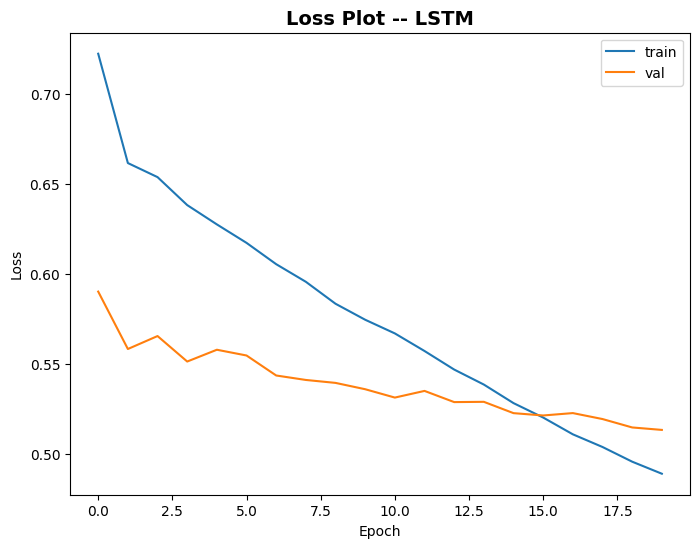

In [244]:
# Plot line graph to show amount loss according the the epoch
plt.figure(figsize=(8,6))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Loss Plot -- LSTM', fontsize=14, color="black", fontweight="bold")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [245]:
inference_result = lstm_model.predict(testX).flatten()

18/18 [==============================] - 0s 2ms/step


In [246]:
y_test.describe()

count   571.000
mean      0.202
std       0.953
min      -4.007
25%       0.000
50%       0.000
75%       0.000
max       4.784
Name: pnls, dtype: float64

In [247]:
pd.Series(inference_result).describe()

count   571.000
mean     -0.001
std       0.008
min      -0.031
25%      -0.004
50%      -0.003
75%       0.001
max       0.052
dtype: float64

In [248]:
lstm_mae = (inference_result - y_test).abs().mean()
lstm_mae

0.4023805081159576

In [249]:
inference_result

array([-0.00668534, -0.00346071, -0.00164529, -0.00451386, -0.00311989,
       -0.00369194, -0.003064  , -0.00346071, -0.00365605,  0.00736671,
       -0.003064  ,  0.00175986,  0.0055512 , -0.00451163, -0.00285286,
        0.0055512 , -0.00289191,  0.0010004 , -0.03126372,  0.01083859,
       -0.00365605,  0.00175986,  0.02893127, -0.00325577,  0.00139596,
        0.00175986, -0.00365605, -0.00512732,  0.00139596, -0.01077856,
       -0.01913397, -0.00365605,  0.00736671, -0.00346071,  0.00175986,
       -0.01547972, -0.01913397,  0.00563806,  0.00563806, -0.00369194,
        0.00563806,  0.0010004 , -0.03126372, -0.00369194, -0.00369194,
        0.00736671, -0.00365605, -0.00285766,  0.00175986, -0.00364763,
        0.00563806,  0.00070095,  0.00736671,  0.0055512 ,  0.00563806,
       -0.03126372, -0.003064  , -0.00354128,  0.00175986, -0.00404587,
       -0.00354128, -0.00757055, -0.00418906, -0.0066027 , -0.00374699,
       -0.00451386, -0.00401362, -0.00698958, -0.003743  , -0.00

In [239]:
mean_abs_label = ((y_test).mean() - y_test).abs().mean()
# lstm_mae / y_test.abs().mean()
lstm_mae / mean_abs_label

0.7540794573910673

In [136]:
# mae = (preds-y_test).abs().mean()
# mae

In [137]:
# mae/mean_abs_label